In [7]:
from typing import Callable, Literal, Optional, Union
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional
from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max
from scipy.optimize import curve_fit

In [8]:
class DefaultPseudoLabeler:
    """Compute pseudo labels based on model predictions, typically from a teacher model.

    Args:
        activation: Activation function applied to the teacher prediction.
        confidence_threshold: Threshold for computing a mask for filtering the pseudo labels.
            If None is given no mask will be computed.
        threshold_from_both_sides: Whether to include both values bigger than the threshold
            and smaller than 1 - the thrhesold, or only values bigger than the threshold, in the mask.
            The former should be used for binary labels, the latter for for multiclass labels.
    """
    def __init__(
        self,
        activation: Optional[torch.nn.Module] = None,
        confidence_threshold: Optional[float] = None,
        threshold_from_both_sides: bool = True,
    ):
        self.activation = activation
        self.confidence_threshold = confidence_threshold
        self.threshold_from_both_sides = threshold_from_both_sides
        # TODO serialize the class names and kwargs for activation instead
        self.init_kwargs = {
            "activation": None, "confidence_threshold": confidence_threshold,
            "threshold_from_both_sides": threshold_from_both_sides
        }

    def _compute_label_mask_both_sides(self, pseudo_labels):
        upper_threshold = self.confidence_threshold
        lower_threshold = 1.0 - self.confidence_threshold
        mask = ((pseudo_labels >= upper_threshold) + (pseudo_labels <= lower_threshold)).to(dtype=torch.float32)
        return mask

    def _compute_label_mask_one_side(self, pseudo_labels):
        mask = (pseudo_labels >= self.confidence_threshold)
        return mask

    def __call__(self, teacher: torch.nn.Module, input_: torch.Tensor) -> torch.Tensor:
        """Compute pseudo-labels.

        Args:
            teacher: The teacher model.
            input_: The input for this batch.

        Returns:
            The pseudo-labels.
        """
        pseudo_labels = teacher(input_)
        if self.activation is not None:
            pseudo_labels = self.activation(pseudo_labels)
        if self.confidence_threshold is None:
            label_mask = None
        else:
            label_mask = self._compute_label_mask_both_sides(pseudo_labels) if self.threshold_from_both_sides\
                else self._compute_label_mask_one_side(pseudo_labels)
        return pseudo_labels, label_mask

    def step(self, metric, epoch):
        pass


In [52]:
class DefaultPseudoLabeler:
    """Compute pseudo labels based on model predictions, typically from a teacher model.

    Args:
        activation: Activation function applied to the teacher prediction.
        confidence_threshold: Threshold for computing a mask for filtering the pseudo labels.
            If None is given no mask will be computed.
        threshold_from_both_sides: Whether to include both values bigger than the threshold
            and smaller than 1 - the thrhesold, or only values bigger than the threshold, in the mask.
            The former should be used for binary labels, the latter for for multiclass labels.
    """
    def __init__(
        self,
        activation: Optional[torch.nn.Module] = None,
        confidence_threshold: Optional[float] = None,
        threshold_from_both_sides: bool = True,
    ):
        self.activation = activation
        self.confidence_threshold = confidence_threshold
        self.threshold_from_both_sides = threshold_from_both_sides
        # TODO serialize the class names and kwargs for activation instead
        self.init_kwargs = {
            "activation": None, "confidence_threshold": confidence_threshold,
            "threshold_from_both_sides": threshold_from_both_sides
        }

    def _compute_label_mask_both_sides(self, pseudo_labels):
        upper_threshold = self.confidence_threshold
        lower_threshold = 1.0 - self.confidence_threshold
        mask = ((pseudo_labels >= upper_threshold) + (pseudo_labels <= lower_threshold)).to(dtype=torch.float32)
        return mask

    def _compute_label_mask_one_side(self, pseudo_labels):
        mask = (pseudo_labels >= self.confidence_threshold)
        return mask

    def __call__(self, teacher: torch.nn.Module, input_: torch.Tensor) -> torch.Tensor:
        """Compute pseudo-labels.

        Args:
            teacher: The teacher model.
            input_: The input for this batch.

        Returns:
            The pseudo-labels.
        """
        pseudo_labels = teacher(input_)
        if self.activation is not None:
            pseudo_labels = self.activation(pseudo_labels)
        if self.confidence_threshold is None:
            label_mask = None
        else:
            label_mask = self._compute_label_mask_both_sides(pseudo_labels) if self.threshold_from_both_sides\
                else self._compute_label_mask_one_side(pseudo_labels)
        return pseudo_labels, label_mask
    
    def visualize_masked_density_separate(self, pseudo_labels: torch.Tensor, label_mask: torch.Tensor, 
                                      axis='z', n_slices=5):
        pseudo_np = pseudo_labels.squeeze().detach().cpu().numpy()
        mask_np = label_mask.squeeze().detach().cpu().numpy().astype(bool)
        
        if self.threshold_from_both_sides:
            background_mask = (pseudo_np <= (1 - self.confidence_threshold))
        else:
            background_mask = np.zeros_like(pseudo_np, dtype=bool)
        print("Foreground mask pixels:", mask_np.sum())  # Should be > 0
        print("Background mask pixels:", background_mask.sum())  # Should be > 0 if threshold_from_both_sides=True
        D, H, W = pseudo_np.shape
        fig, axs = plt.subplots(3, n_slices, figsize=(15, 9))
        
        for i, idx in enumerate(np.linspace(0, D-1 if axis=='z' else H-1 if axis=='y' else W-1, n_slices, dtype=int)):
            if axis == 'z':
                slc = pseudo_np[idx,:,:]
                mask_slc = mask_np[idx,:,:]
                bg_slc = background_mask[idx,:,:]
            elif axis == 'y':
                slc = pseudo_np[:,idx,:]
                mask_slc = mask_np[:,idx,:]
                bg_slc = background_mask[:,idx,:]
            else:
                slc = pseudo_np[:,:,idx]
                mask_slc = mask_np[:,:,idx]
                bg_slc = background_mask[:,:,idx]
            
            axs[0,i].imshow(slc, cmap='viridis')
            axs[0,i].set_title(f'Density {axis}={idx}')
            
            #axs[1,i].imshow(slc, cmap='gray')
            particles = np.ma.masked_where(~(mask_slc & ~bg_slc), np.ones_like(slc))
            background = np.ma.masked_where(~bg_slc, np.ones_like(slc))
            axs[1,i].imshow(particles, cmap='Greens', alpha=0.7)
            axs[1,i].imshow(background, cmap='Blues', alpha=0.3)
            axs[1,i].set_title('Confidence map')
            
            # Dynamically adjust bins for the histogram
            data_range = slc.max() - slc.min()
            bins = min(50, max(1, int(data_range * 10)))
            axs[2,i].hist(slc.ravel(), bins=bins, color='gray')
            axs[2,i].axvline(self.confidence_threshold, color='green', linestyle='--', label='Foreground thresh')
            if self.threshold_from_both_sides:
                axs[2,i].axvline(1-self.confidence_threshold, color='blue', linestyle='--', label='Background thresh')
            axs[2,i].legend()
        
        plt.tight_layout()
        plt.show()

    def visualize_masked_density(self, pseudo_labels: torch.Tensor, label_mask: torch.Tensor, 
                           axis='z', n_slices=5):
        """Clear visualization with proper green confidence regions"""
    
        # Convert tensors to numpy
        pseudo_np = pseudo_labels.squeeze().detach().cpu().numpy()
        mask_np = label_mask.squeeze().detach().cpu().numpy()
        
        assert pseudo_np.shape == mask_np.shape, "Shape mismatch!"

        D, H, W = pseudo_np.shape
        
        # Get slice indices
        if axis == 'z':
            indices = np.linspace(0, D-1, n_slices, dtype=int)
        elif axis == 'y':
            indices = np.linspace(0, H-1, n_slices, dtype=int)
        elif axis == 'x':
            indices = np.linspace(0, W-1, n_slices, dtype=int)
        
        fig, axs = plt.subplots(2, n_slices, figsize=(15, 6))
        
        for i, idx in enumerate(indices):
            # Get slices
            if axis == 'z':
                density_slice = pseudo_np[idx, :, :]
                mask_slice = mask_np[idx, :, :]
            elif axis == 'y':
                density_slice = pseudo_np[:, idx, :]
                mask_slice = mask_np[:, idx, :]
            elif axis == 'x':
                density_slice = pseudo_np[:, :, idx]
                mask_slice = mask_np[:, :, idx]
            
            # Top: Density only
            im0 = axs[0,i].imshow(density_slice, cmap='viridis')
            axs[0,i].set_title(f'Density at {axis}={idx}')
            plt.colorbar(im0, ax=axs[0,i])
            
            # Bottom: Overlay - FIXED THE GREEN DISPLAY HERE
            axs[1,i].imshow(density_slice, cmap='gray')
            # Create proper green overlay (only where mask=1)
            overlay = np.ma.masked_where(mask_slice == 0, mask_slice)
            im1 = axs[1,i].imshow(overlay, cmap='Greens', alpha=0.5, vmin=0, vmax=1)
            axs[1,i].set_title(f'Confidence at {axis}={idx}')
            
        plt.tight_layout()
        plt.show()
    def visualize_masked_density_separate_new(self, pseudo_labels: torch.Tensor, label_mask: torch.Tensor, 
                                    axis='z', n_slices=5):
        pseudo_np = pseudo_labels.squeeze().detach().cpu().numpy()
        mask_np = label_mask.squeeze().detach().cpu().numpy().astype(bool)
        
        if self.threshold_from_both_sides:
            background_mask = (pseudo_np <= (1 - self.confidence_threshold))
        else:
            background_mask = np.zeros_like(pseudo_np, dtype=bool)
        
        D, H, W = pseudo_np.shape
        fig, axs = plt.subplots(3, n_slices, figsize=(15, 9))
        
        for i, idx in enumerate(np.linspace(0, D-1 if axis=='z' else H-1 if axis=='y' else W-1, n_slices, dtype=int)):
            if axis == 'z':
                slc = pseudo_np[idx,:,:]
                mask_slc = mask_np[idx,:,:]
                bg_slc = background_mask[idx,:,:]
            elif axis == 'y':
                slc = pseudo_np[:,idx,:]
                mask_slc = mask_np[:,idx,:]
                bg_slc = background_mask[:,idx,:]
            else:
                slc = pseudo_np[:,:,idx]
                mask_slc = mask_np[:,:,idx]
                bg_slc = background_mask[:,:,idx]
            
            # Row 1: Density
            axs[0,i].imshow(slc, cmap='viridis')
            axs[0,i].set_title(f'Density {axis}={idx}')
            
            # Row 2: Confidence Map (Fixed)
            slc_normalized = (slc - slc.min()) / (slc.max() - slc.min())
            axs[1,i].imshow(slc_normalized, cmap='gray', vmin=0, vmax=1)
            
            particles = np.ma.masked_where(~mask_slc, np.ones_like(slc))  # Green
            background = np.ma.masked_where(~(bg_slc & ~mask_slc), np.ones_like(slc))  # Blue
            axs[1,i].imshow(particles, cmap='Greens', alpha=0.7)
            axs[1,i].imshow(background, cmap='Blues', alpha=0.3)
            axs[1,i].set_title('Confidence map')
            
            # Row 3: Histogram
            data_range = slc.max() - slc.min()
            bins = min(50, max(1, int(data_range * 10)))
            axs[2,i].hist(slc.ravel(), bins=bins, color='gray')
            axs[2,i].axvline(self.confidence_threshold, color='green', linestyle='--', label='Foreground thresh')
            if self.threshold_from_both_sides:
                axs[2,i].axvline(1-self.confidence_threshold, color='blue', linestyle='--', label='Background thresh')
            axs[2,i].legend()
        
        plt.tight_layout()
        plt.show()
    def step(self, metric, epoch):
        pass


Input tensor shape: torch.Size([32, 32, 32])
Input tensor min/max: tensor(4.7153e-39) tensor(1.0000)
Input tensor tensor([[5.1756e-17, 5.5642e-16, 4.6589e-15,  ..., 3.5083e-31, 2.6786e-33,
         1.5928e-35],
        [5.5642e-16, 5.9821e-15, 5.0088e-14,  ..., 3.7718e-30, 2.8798e-32,
         1.7124e-34],
        [4.6589e-15, 5.0088e-14, 4.1938e-13,  ..., 3.1581e-29, 2.4113e-31,
         1.4339e-33],
        ...,
        [3.5083e-31, 3.7718e-30, 3.1581e-29,  ..., 5.6707e-33, 1.9404e-34,
         5.1710e-36],
        [2.6786e-33, 2.8798e-32, 2.4113e-31,  ..., 1.9404e-34, 6.6397e-36,
         1.7694e-37],
        [1.5928e-35, 1.7124e-34, 1.4339e-33,  ..., 5.1710e-36, 1.7694e-37,
         4.7153e-39]])
Pseudo labels shape: torch.Size([32, 32, 32])
Pseudo labels tensor([[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        ...,
        [0.5000, 0.5000, 

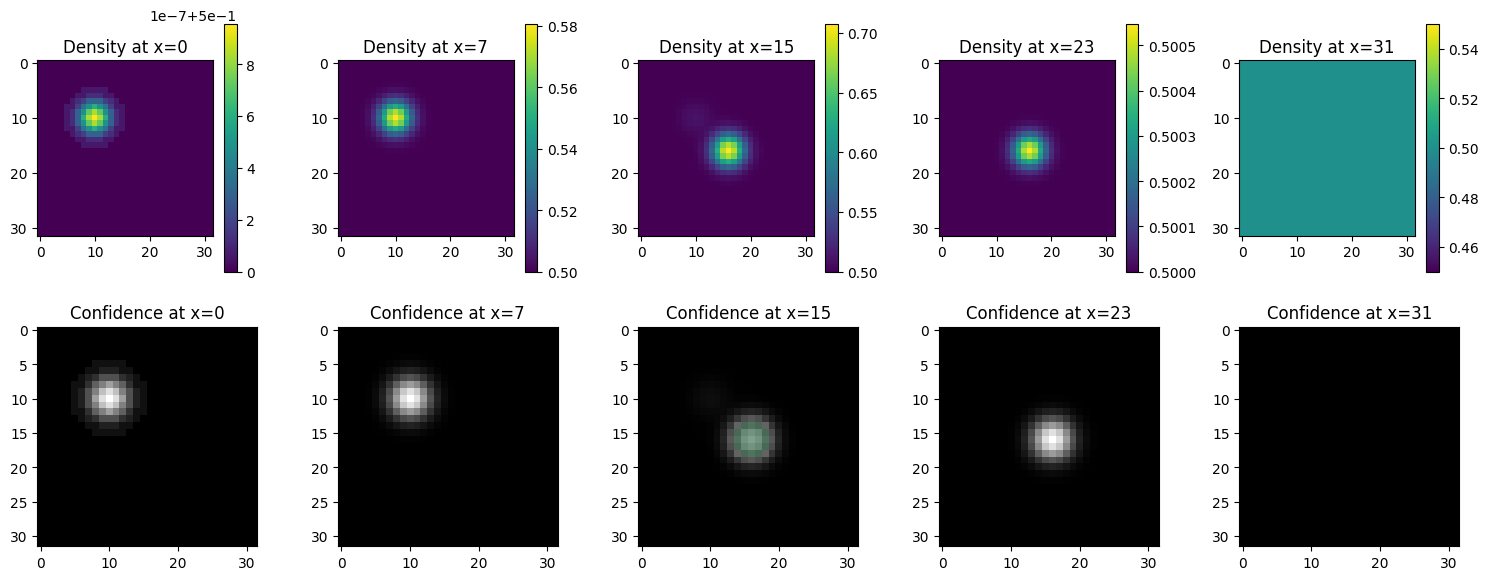

In [67]:
# Import necessary libraries
import torch
import numpy as np

# Define a dummy teacher model for demonstration
class DummyTeacherModel(torch.nn.Module):
    def forward(self, x):
        # Example: Apply a simple transformation
        return x

# Instantiate the teacher model
teacher_model = DummyTeacherModel()

def create_synthetic_density_map(shape=(32,32,32), centers=[(16,16,16), (10,10,10)], sigma=2.0):
    data = np.zeros(shape, dtype=np.float32)
    zz, yy, xx = np.indices(shape)
    for z0, y0, x0 in centers:
        gauss = np.exp(-(((xx - x0)**2 + (yy - y0)**2 + (zz - z0)**2) / (2*sigma**2)))
        data += gauss
    return torch.tensor(data)  # (1,1,D,H,W)

# Create a synthetic density map
input_tensor = create_synthetic_density_map()
print("Input tensor shape:", input_tensor.shape)  # Should be (1,1,D,H,W)
print("Input tensor min/max:", input_tensor.min(), input_tensor.max())  
print("Input tensor",input_tensor[0])# Check the range of values
# Instantiate the DefaultPseudoLabeler
default_pseudo_labeler = DefaultPseudoLabeler(
    activation=torch.nn.Sigmoid(),  # Example activation function
    confidence_threshold=0.6,       # Example confidence threshold
    threshold_from_both_sides=True,  # Use both sides of the threshold
)

# Compute pseudo-labels and label mask
pseudo_labels, label_mask = default_pseudo_labeler(teacher_model, input_tensor)
print("Pseudo labels shape:", pseudo_labels.shape)
print("Pseudo labels",pseudo_labels[0])  # Should be (1,1,D,H,W)
print("Label mask shape:", label_mask.shape)  # Should be (1,1,D,H,W)
print("Label mask min/max:", label_mask.min(), label_mask.max())  # Check the range of values


# Visualize the masked density
default_pseudo_labeler.visualize_masked_density(
    pseudo_labels=pseudo_labels,
    label_mask=label_mask,
    axis='x',  # Choose the axis for slicing ('z', 'y', or 'x')
    n_slices=5 # Number of slices to visualize
)

input_tensor: tensor([[0.0000, 0.0402, 0.0000,  ..., 0.1045, 0.0912, 0.0730],
        [0.1315, 0.0556, 0.0000,  ..., 0.0000, 0.0600, 0.0179],
        [0.0140, 0.0620, 0.1273,  ..., 0.0000, 0.2035, 0.0000],
        ...,
        [0.0377, 0.0091, 0.0000,  ..., 0.0450, 0.1363, 0.0000],
        [0.0000, 0.1840, 0.0000,  ..., 0.0118, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0432]])
pseudo_labels: tensor([[0.0000, 0.0402, 0.0000,  ..., 0.1045, 0.0912, 0.0730],
        [0.1315, 0.0556, 0.0000,  ..., 0.0000, 0.0600, 0.0179],
        [0.0140, 0.0620, 0.1273,  ..., 0.0000, 0.2035, 0.0000],
        ...,
        [0.0377, 0.0091, 0.0000,  ..., 0.0450, 0.1363, 0.0000],
        [0.0000, 0.1840, 0.0000,  ..., 0.0118, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0432]])
label_mask: tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1.,

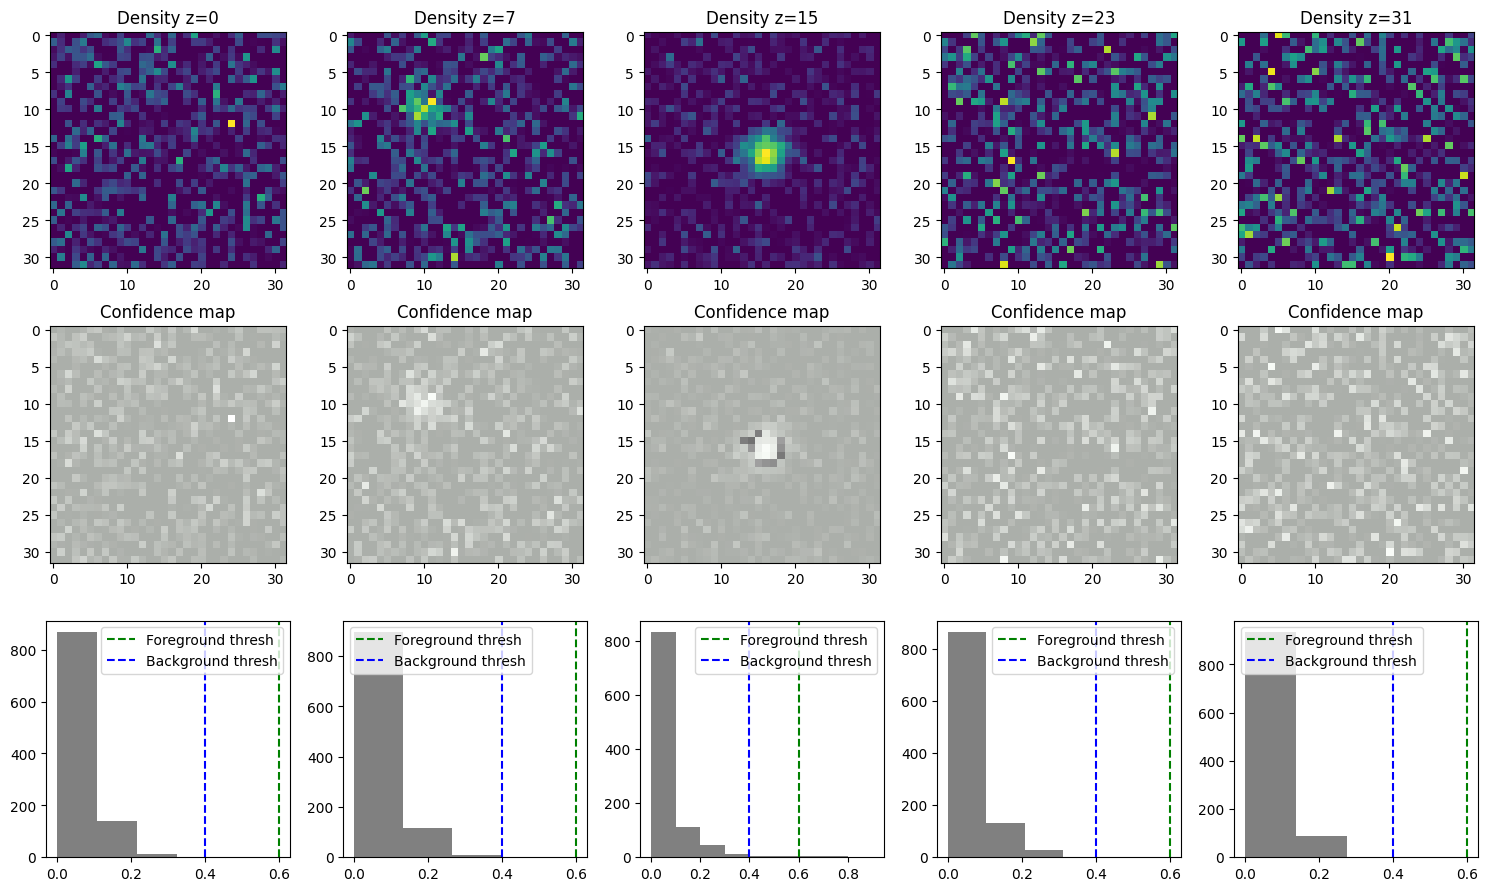

Evaluation Results: {'MSE': np.float32(0.10506448), 'Masked MSE': np.float32(0.10491228)}


In [70]:
# Import necessary libraries
import torch
import numpy as np

# Define a dummy teacher model (Identity Teacher)
class IdentityTeacherModel(torch.nn.Module):
    def forward(self, x):
        # Identity transformation (returns input as is)
        return x

# Instantiate the teacher model
teacher_model = IdentityTeacherModel()

def create_synthetic_density_map(shape=(32,32,32), centers=[(16,16,16), (10,10,10)], sigma=2.0, noise_level=0.1):
    """
    Create a synthetic density map with optional Gaussian noise.

    Args:
        shape: Shape of the density map (D, H, W).
        centers: List of center coordinates for Gaussian blobs.
        sigma: Standard deviation of the Gaussian blobs.
        noise_level: Standard deviation of the added Gaussian noise.

    Returns:
        A torch tensor representing the synthetic density map.
    """
    data = np.zeros(shape, dtype=np.float32)
    zz, yy, xx = np.indices(shape)
    for z0, y0, x0 in centers:
        gauss = np.exp(-(((xx - x0)**2 + (yy - y0)**2 + (zz - z0)**2) / (2 * sigma**2)))
        data += gauss
    # Add Gaussian noise
    noise = np.random.normal(0, noise_level, size=shape).astype(np.float32)
    data += noise
    data = np.clip(data, 0, 1)  # Ensure values are in [0, 1]
    return torch.tensor(data)

# Create a synthetic density map with noise
input_tensor = create_synthetic_density_map(noise_level=0.1)
print("input_tensor:",input_tensor[0])
# Instantiate the DefaultPseudoLabeler
default_pseudo_labeler = DefaultPseudoLabeler(
    activation=None,  # Example activation function
    confidence_threshold=0.6,       # Example confidence threshold
    threshold_from_both_sides=True  # Use both sides of the threshold
)

# Compute pseudo-labels and label mask
pseudo_labels, label_mask = default_pseudo_labeler(teacher_model, input_tensor,)
print("pseudo_labels:",pseudo_labels[0])
print("label_mask:",label_mask[0])
# Visualize the masked density
default_pseudo_labeler.visualize_masked_density_separate_new(
    pseudo_labels=pseudo_labels,
    label_mask=label_mask,
    axis='z',  # Choose the axis for slicing ('z', 'y', or 'x')
    n_slices=5 # Number of slices to visualize
)

# Evaluate the results
def evaluate_pseudo_labels(pseudo_labels, label_mask, ground_truth):
    """
    Evaluate the pseudo-labels against the ground truth.

    Args:
        pseudo_labels: The pseudo-labels generated by the teacher model.
        label_mask: The confidence mask for the pseudo-labels.
        ground_truth: The ground truth density map.

    Returns:
        A dictionary with evaluation metrics (e.g., MSE, masked MSE).
    """
    pseudo_np = pseudo_labels.detach().cpu().numpy()
    mask_np = label_mask.detach().cpu().numpy()
    ground_truth_np = ground_truth.detach().cpu().numpy()

    mse = np.mean((pseudo_np - ground_truth_np)**2)
    masked_mse = np.mean(((pseudo_np - ground_truth_np)**2)[mask_np > 0])

    return {"MSE": mse, "Masked MSE": masked_mse}

# Create a ground truth density map (without noise)
ground_truth = create_synthetic_density_map(noise_level=0.5)

# Evaluate the pseudo-labels
evaluation_results = evaluate_pseudo_labels(pseudo_labels, label_mask, ground_truth)
print("Evaluation Results:", evaluation_results)

tensor([[[0.0000, 0.0000, 0.3173,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.3401, 0.5225, 0.0000],
         [0.0000, 0.0000, 0.5237,  ..., 0.0000, 0.3949, 0.1646],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0841, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.3102,  ..., 0.0000, 0.5776, 0.3125],
         [0.6730, 0.0000, 0.1023,  ..., 0.0707, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.1553, 0.0000, 0.1255],
         [0.0000, 0.0000, 1.0000,  ..., 0.2179, 0.0000, 0.0000],
         [0.0000, 0.4018, 0.0000,  ..., 0.0000, 0.2357, 0.0000],
         ...,
         [0.1965, 0.6836, 0.0000,  ..., 0.1714, 0.0000, 1.0000],
         [0.0000, 0.0000, 0.6645,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.5909,  ..., 0.3306, 0.6862, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.5817, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.2932,  ..., 0.2703, 0.0000, 0.0000],
         [0.2048, 0.2347, 0.0000,  ..., 0.7123, 0.1516, 0.

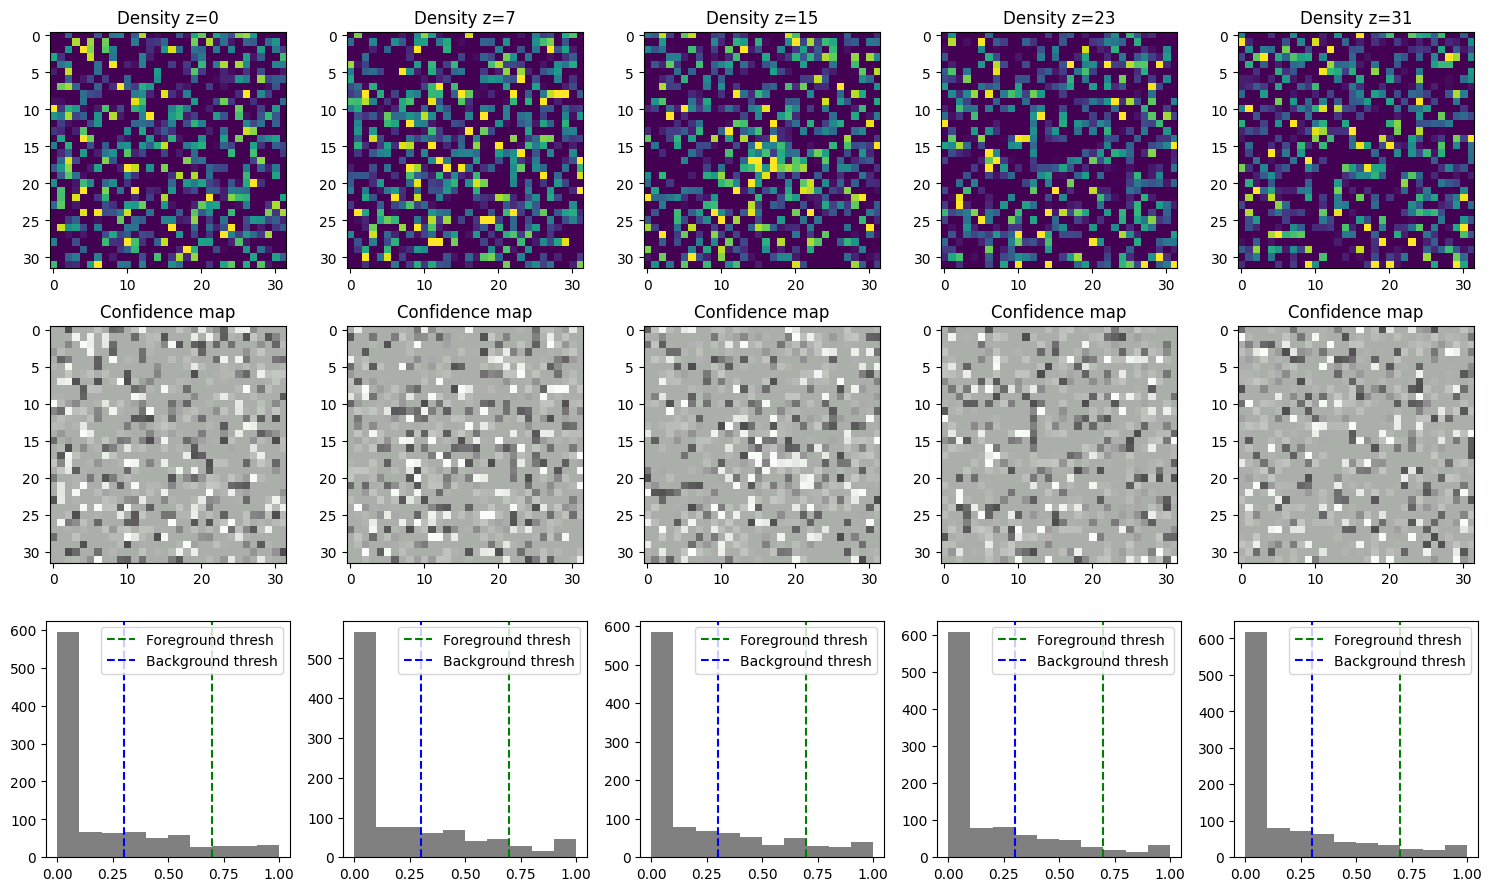

In [73]:
# Create synthetic data (no clipping, let activation handle it)
input_tensor = create_synthetic_density_map(noise_level=0.5)  # Lower noise
ground_truth = create_synthetic_density_map(noise_level=0.0)   # Noise-free GT

# Initialize pseudo-labeler with Sigmoid
pseudo_labeler = DefaultPseudoLabeler(
    activation=None,
    confidence_threshold=0.7,  # Less strict threshold
    threshold_from_both_sides=True
)
print(input_tensor)
# Generate pseudo-labels
pseudo_labels, label_mask = pseudo_labeler(teacher_model, input_tensor)

print("Pseudo labels shape:", pseudo_labels.shape)
print(pseudo_labels.min(), pseudo_labels.max())
# Check mask coverage
print(f"Mask coverage: {label_mask.sum().item() / label_mask.numel():.1%}")

# Evaluate
results = evaluate_pseudo_labels(pseudo_labels, label_mask, ground_truth)
print("Evaluation:", results)

# Visualize
pseudo_labeler.visualize_masked_density_separate_new(pseudo_labels, label_mask, axis='z')